This is an example to infer eccentricities for individual wide binaries, reproducing the result in Fig. 8 in [Hwang et al. 2022](https://arxiv.org/abs/2111.01789)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table
import astropy.units as u
%matplotlib inline 

In [3]:
from matplotlib import rcParams
rcParams.update({'font.size': '18'})
rcParams.update({'font.family': 'sans-serif'})
rcParams.update({'axes.facecolor': 'white'})
rcParams.update({'axes.edgecolor': 'black'})
rcParams.update({'axes.labelcolor': 'black'})
rcParams.update({'xtick.top': 'True'})
rcParams.update({'xtick.major.pad': '6.0'})
rcParams.update({'xtick.color': 'k'})
rcParams.update({'xtick.direction': 'in'})
rcParams.update({'ytick.right': 'True'})
rcParams.update({'ytick.major.pad': '6.0'})
rcParams.update({'ytick.color': 'k'})
rcParams.update({'ytick.direction': 'in'})
rcParams.update({'legend.fontsize': '18'})
rcParams.update({'figure.figsize': '8.0, 6.0'})
rcParams.update({'figure.dpi': '100'})
rcParams.update({'figure.facecolor': 'white'})
rcParams.update({'figure.edgecolor': 'white'})
rcParams.update({'image.cmap': 'rainbow'})

Read wide binary table, which contains two rows from the eDR3 wide binary catalog ([El-Badry et al. 2021](https://ui.adsabs.harvard.edu/abs/2021MNRAS.506.2269E/abstract))


In [4]:
wb_table = Table.read('example_binary.fits')

Take a look at the content:

In [5]:
wb_table

solution_id1,solution_id2,source_id1,source_id2,random_index1,random_index2,ref_epoch1,ref_epoch2,ra1,ra2,ra_error1,ra_error2,dec1,dec2,dec_error1,dec_error2,parallax1,parallax2,parallax_error1,parallax_error2,parallax_over_error1,parallax_over_error2,pm1,pm2,pmra1,pmra2,pmra_error1,pmra_error2,pmdec1,pmdec2,pmdec_error1,pmdec_error2,ra_dec_corr1,ra_dec_corr2,ra_parallax_corr1,ra_parallax_corr2,ra_pmra_corr1,ra_pmra_corr2,ra_pmdec_corr1,ra_pmdec_corr2,dec_parallax_corr1,dec_parallax_corr2,dec_pmra_corr1,dec_pmra_corr2,dec_pmdec_corr1,dec_pmdec_corr2,parallax_pmra_corr1,parallax_pmra_corr2,parallax_pmdec_corr1,parallax_pmdec_corr2,pmra_pmdec_corr1,pmra_pmdec_corr2,astrometric_n_obs_al1,astrometric_n_obs_al2,astrometric_n_obs_ac1,astrometric_n_obs_ac2,astrometric_n_good_obs_al1,astrometric_n_good_obs_al2,astrometric_n_bad_obs_al1,astrometric_n_bad_obs_al2,astrometric_gof_al1,astrometric_gof_al2,astrometric_chi2_al1,astrometric_chi2_al2,astrometric_excess_noise1,astrometric_excess_noise2,astrometric_excess_noise_sig1,astrometric_excess_noise_sig2,astrometric_params_solved1,astrometric_params_solved2,astrometric_primary_flag1,astrometric_primary_flag2,nu_eff_used_in_astrometry1,nu_eff_used_in_astrometry2,pseudocolour1,pseudocolour2,pseudocolour_error1,pseudocolour_error2,ra_pseudocolour_corr1,ra_pseudocolour_corr2,dec_pseudocolour_corr1,dec_pseudocolour_corr2,parallax_pseudocolour_corr1,parallax_pseudocolour_corr2,pmra_pseudocolour_corr1,pmra_pseudocolour_corr2,pmdec_pseudocolour_corr1,pmdec_pseudocolour_corr2,astrometric_matched_transits1,astrometric_matched_transits2,visibility_periods_used1,visibility_periods_used2,astrometric_sigma5d_max1,astrometric_sigma5d_max2,matched_transits1,matched_transits2,new_matched_transits1,new_matched_transits2,matched_transits_removed1,matched_transits_removed2,ipd_gof_harmonic_amplitude1,ipd_gof_harmonic_amplitude2,ipd_gof_harmonic_phase1,ipd_gof_harmonic_phase2,ipd_frac_multi_peak1,ipd_frac_multi_peak2,ipd_frac_odd_win1,ipd_frac_odd_win2,ruwe1,ruwe2,scan_direction_strength_k11,scan_direction_strength_k12,scan_direction_strength_k21,scan_direction_strength_k22,scan_direction_strength_k31,scan_direction_strength_k32,scan_direction_strength_k41,scan_direction_strength_k42,scan_direction_mean_k11,scan_direction_mean_k12,scan_direction_mean_k21,scan_direction_mean_k22,scan_direction_mean_k31,scan_direction_mean_k32,scan_direction_mean_k41,scan_direction_mean_k42,duplicated_source1,duplicated_source2,phot_g_n_obs1,phot_g_n_obs2,phot_g_mean_flux1,phot_g_mean_flux2,phot_g_mean_flux_error1,phot_g_mean_flux_error2,phot_g_mean_flux_over_error1,phot_g_mean_flux_over_error2,phot_g_mean_mag1,phot_g_mean_mag2,phot_bp_n_obs1,phot_bp_n_obs2,phot_bp_mean_flux1,phot_bp_mean_flux2,phot_bp_mean_flux_error1,phot_bp_mean_flux_error2,phot_bp_mean_flux_over_error1,phot_bp_mean_flux_over_error2,phot_bp_mean_mag1,phot_bp_mean_mag2,phot_rp_n_obs1,phot_rp_n_obs2,phot_rp_mean_flux1,phot_rp_mean_flux2,phot_rp_mean_flux_error1,phot_rp_mean_flux_error2,phot_rp_mean_flux_over_error1,phot_rp_mean_flux_over_error2,phot_rp_mean_mag1,phot_rp_mean_mag2,phot_bp_n_contaminated_transits1,phot_bp_n_contaminated_transits2,phot_bp_n_blended_transits1,phot_bp_n_blended_transits2,phot_rp_n_contaminated_transits1,phot_rp_n_contaminated_transits2,phot_rp_n_blended_transits1,phot_rp_n_blended_transits2,phot_proc_mode1,phot_proc_mode2,phot_bp_rp_excess_factor1,phot_bp_rp_excess_factor2,bp_rp1,bp_rp2,bp_g1,bp_g2,g_rp1,g_rp2,dr2_radial_velocity1,dr2_radial_velocity2,dr2_radial_velocity_error1,dr2_radial_velocity_error2,dr2_rv_nb_transits1,dr2_rv_nb_transits2,dr2_rv_template_teff1,dr2_rv_template_teff2,dr2_rv_template_logg1,dr2_rv_template_logg2,dr2_rv_template_fe_h1,dr2_rv_template_fe_h2,l1,l2,b1,b2,ecl_lon1,ecl_lon2,ecl_lat1,ecl_lat2,pairdistance,sep_AU,binary_type,Sigma18,R_chance_align,dr2_source_id1,dr2_source_id2,dr2_parallax1,dr2_parallax2,dr2_parallax_error1,dr2_parallax_error2,dr2_pmra1,dr2_pmra2,dr2_pmdec1,dr2_pmdec2,dr2_pmra_error1,dr2

Calculate their v-r angles:

In [6]:
#difference in ra-dec coordinates
wb_table['dra'] = (wb_table['ra2'] - wb_table['ra1']) * np.cos((wb_table['dec1']+wb_table['dec2'])/2. * np.pi / 180.)
wb_table['ddec'] = (wb_table['dec2'] - wb_table['dec1'])
wb_table['dradec'] = np.sqrt(wb_table['dra']**2 + wb_table['ddec']**2)

#difference in proper motions
wb_table['dpmra'] = wb_table['pmra2'] - wb_table['pmra1']
wb_table['dpmdec'] = wb_table['pmdec2'] - wb_table['pmdec1']
wb_table['dpmradec'] = np.sqrt(wb_table['dpmra']**2 + wb_table['dpmdec']**2)

#v-r angles
wb_table['vr_angle'] = 180. / np.pi * np.arccos((wb_table['dra'] * wb_table['dpmra'] + wb_table['ddec'] * wb_table['dpmdec']) / wb_table['dpmradec'] / wb_table['dradec'])


#uncertainties of proper motion differences and v-r angles
wb_table['dpm_error'] = 1. / wb_table['dpmradec'] * np.sqrt(
        wb_table['dpmra']**2 * (wb_table['pmra_error1']**2 + wb_table['pmra_error2']**2) +
        wb_table['dpmdec']**2 * (wb_table['pmdec_error1']**2 + wb_table['pmdec_error2']**2) 
    )

wb_table['dpm_over_error'] = wb_table['dpmradec'] / wb_table['dpm_error']

wb_table['vr_angle_error'] = 180. / np.pi / wb_table['dpm_over_error']

wb_table['vr_angle_error'].unit = u.deg

These two wide binaries have very different v-r angles: one is 3.6 deg and one is 86.5 deg.

In [7]:
wb_table['vr_angle', 'vr_angle_error']

vr_angle,vr_angle_error
deg,deg
float64,float64
3.6413306877496443,5.778451022426986
86.47111194060301,5.387229366396684


Below we infer the probability distribution function (PDF) of their individual eccentricties, $p(e|\gamma_{obs})$ where $\gamma_{obs}$ is the observed v-r angle. The Bayes' theorem says

$$p(e|\gamma_{obs}) \propto p(\gamma_{obs}|e) p(e)$$

And we marginalize over the uncertainty of the v-r angle:

$$p(e|\gamma_{obs}) \propto \int p(\gamma_{obs}|\gamma_{true}) p(\gamma_{true}|e) p(e) d\gamma_{true},$$
where $p(\gamma_{obs}|\gamma_{true})$ is a Gaussian (truncated at 0 and 180 deg) with a width of v-r angle uncertainty.


The term $p(\gamma_{true}|e)$ is pre-computed from simulations. Here we load the result. See more details in "Demo 1 - Using p(gamma|e) grid" notebook.


In [8]:
from scipy import interpolate

e_list, vr_angle_list_center, hist_list = np.load('./grid_data/data.npy', allow_pickle=True)
p_gamma_bar_e = interpolate.interp2d(e_list, vr_angle_list_center, hist_list.T, kind='cubic')

First we define a function to compute the truncated Gaussian for $ p(\gamma_{obs}|\gamma_{true}) $. scipy 1.7 is needed here.

In [13]:
import scipy
from scipy import stats

def vr_angle_pdf_gaussian(vr_angle, vr_angle_error, vr_angle_list=np.arange(0., 181., 1.)):
    
    gaussian = scipy.stats.norm(vr_angle, vr_angle_error).pdf(vr_angle_list) 
    return gaussian / np.sum(gaussian)

In [10]:
scipy.__version__

'1.7.3'

Then we compute the integration $\int p(\gamma_{obs}|\gamma_{true}) p(\gamma_{true}|e) d\gamma_{true}$ for these two wide binaries. We do this integration for each $e$ from 0 to 1.

In [14]:
p_gamma_bar_e_list = []

#grid for integration
e_dense_list = np.arange(0., 1., 0.01)
vr_angle_list_to_integrate = np.arange(0., 181., 1)

N_vr_angle_list = len(vr_angle_list_to_integrate)


for pair in wb_table:
    
    #initialize the array as zero
    p_e_bar_gamma = np.zeros_like(e_dense_list)
    
    vr_angle_obs = pair['vr_angle']
    vr_angle_error_obs = pair['vr_angle_error']
    
    #compute the Gaussian
    vr_angle_pdf = vr_angle_pdf_gaussian(vr_angle_obs, vr_angle_error_obs)

    #integrate (i.e. summation) over vr angle from 0 to 180 
    p_e_bar_gamma = np.sum(p_gamma_bar_e(e_dense_list,vr_angle_list_to_integrate)* vr_angle_pdf[:,None], axis=0)

    p_gamma_bar_e_list.append(p_e_bar_gamma)

We then need to determine the prior $p(e)$. In [Hwang et al. 2022](https://arxiv.org/abs/2111.01789), we measure the eccentricity distribution (parametrized by a power law, $p(e)\propto e^\alpha$) as a function of binary separations. Then we describe the relation between $\alpha$ (eccentricity distribution) and binary separation using a tanh() function. Below we calculate this $\alpha$ for these two binaries based on their separations.

In [19]:
A = 0.91
B = 2.29
C = 0.61
D = 0.44

wb_table['alpha'] = A * np.tanh( (np.log10(wb_table['sep_AU']) - B) / C ) + D

Check their alpha:

In [20]:
wb_table['sep_AU', 'alpha']

sep_AU,alpha
float64,float64
593.6999231386775,1.040558469331088
568.938879838245,1.0246658896944782


For the purpse of this jupyter notebook (and Fig. 8 in [Hwang et al. 2022](https://arxiv.org/abs/2111.01789) ), we explore how different priors affect the eccentricity inference using $\alpha$=0, 0.5, and 1. Below, for each $\alpha$, we calculate the $p(e|\gamma_{obs})$ by multiplying the $\int p(\gamma_{obs}|\gamma_{true}) p(\gamma_{true}|e) d\gamma_{true}$ computed above with the prior $p(e)=(1+\alpha)e^\alpha$.

Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.
Substituting with a symbol from Computer Modern.


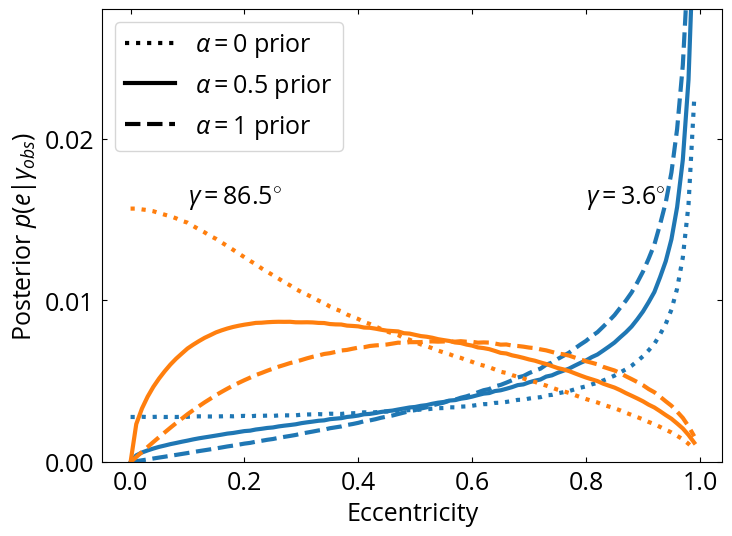

In [22]:


e_dense_list = np.arange(0., 1., 0.01)

for i, pair in enumerate(wb_table):

    alpha= 0.5
    
    #load the pre-computed integration
    p_gamma_bar_e = p_gamma_bar_e_list[i]
    lw=3
    
    #alpha=0.5 prior
    plt.plot(
        e_dense_list,
        p_gamma_bar_e * (1. + alpha) * e_dense_list**alpha,
        c='C%d' %(i), lw=lw
    )
    
    #alpha=0 prior
    plt.plot(
        e_dense_list,
        p_gamma_bar_e,
        c='C%d' %(i), ls=':', lw=lw
    )
    
    #alpha=1 prior
    plt.plot(
        e_dense_list,
        p_gamma_bar_e * (2. * e_dense_list),
        c='C%d' %(i), ls='--', lw=lw
    )
    
    
    
    plt.text(
        [0.8, 0.1][i],
        [0.016, 0.016][i],
        r'$\gamma=%.1f^{\circ}$' %(pair['vr_angle'])
    )

    i+=1

    
    
plt.plot(
    [],[], ls=':',
    label=r'$\alpha=0$ prior',
    c='k', lw=lw
)

plt.plot(
    [],[], 
    label=r'$\alpha=0.5$ prior',
    c='k', lw=lw
)


plt.plot(
    [],[], ls='--',
    label=r'$\alpha=1$ prior',
    c='k', lw=lw
)

plt.legend()

plt.ylim(0, 0.028)

plt.xlabel('Eccentricity')
plt.ylabel(r'Posterior $p(e|\gamma_{obs})$')
plt.yticks([0, 0.01, 0.02])

plt.show()

We provide the measurement summary of these eccentricity PDF for all eDR3 wide binaries! Check it out: 